# (07) Neural analysis (GABAN; tmp)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
path = results_dir()
path = pathlib.Path(path)

trainer_paths = set()
pat = '**/Trainer' # '**/*fixate1*/**/Trainer'
for p in path.rglob(pat):
    if p.is_dir():
        trainer_paths.add(str(p))
trainer_paths = sorted(trainer_paths)

In [3]:
for fit_path in trainer_paths:
    fit_name = fit_path.split('/')[-2]
    
    if 'fixate1_nf-420_(2023_04_27,20:20)' not in fit_name:
        continue
    
    f = pjoin(tmp_dir, 'trainer_analysis', fit_name)
    f = f"{f}.npy"
    if os.path.isfile(f):
        everything = np.load(f, allow_pickle=True).item()
        break

In [4]:
fit_name

'fixate1_nf-420_(2023_04_27,20:20)'

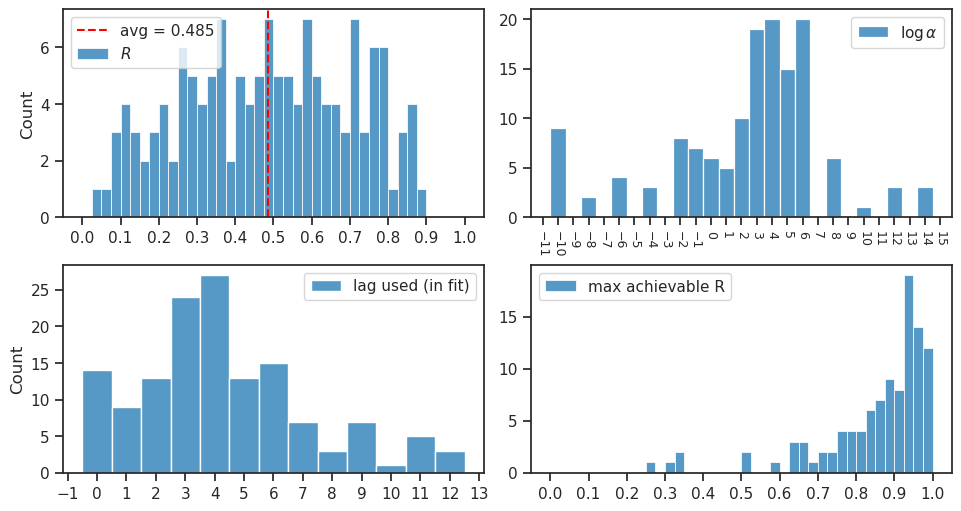

141

In [5]:
df, df_all, ro_all, args, tr = summarize_neural_fits(
    fit_name=fit_name, device='cpu')
_ = show_neural_results(df)
len(df)

## One cell

In [6]:
%%time

expt, cell = 'clu267', 4
ro = ro_all[f'YUWEI_{expt}']
neural_data = ro.validate(cell)

neural_data['y'].sum() / (len(neural_data['y']) * 25e-3)

CPU times: user 21min 50s, sys: 1min 15s, total: 23min 6s
Wall time: 56.8 s


19.790658905195265

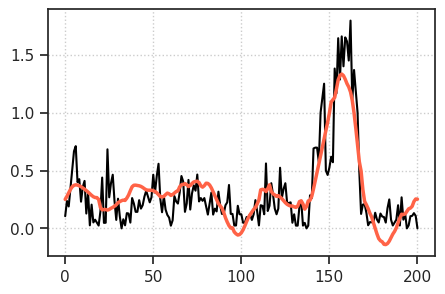

In [7]:
pred = ro.mod[cell].predict(neural_data['x_tst'])

plt.plot(neural_data['y_tst'], color='k', lw=1.5)
plt.plot(pred, color='tomato', lw=2.5)
plt.grid()
plt.show()

In [8]:
r = sp_stats.pearsonr(neural_data['y_tst'], pred)[0]
r2 = sk_metric.r2_score(neural_data['y_tst'], pred) * 100
r, r2

(0.8465311622004383, 71.56910036781706)

In [9]:
list(neural_data)

['x', 'y', 'x_tst', 'y_tst']

In [12]:
print({k: v.shape for k, v in neural_data.items()})

{'x': (36591, 420), 'y': (36591,), 'x_tst': (201, 420), 'y_tst': (201,)}

In [13]:
pred_full = ro.mod[cell].predict(neural_data['x'])
ro.stim[ro.good].shape, pred_full.shape

((36591, 2, 17, 17), (36591,))

In [14]:
sta_model = compute_sta(
    n_lags=0,
    stim=ro.stim[ro.good],
    spks=pred_full.reshape(-1, 1),
)

/home/hadi/Dropbox/git/_MTMST/analysis/linear.py:293: RuntimeWarning: NaN in STA
  warnings.warn("NaN in STA", RuntimeWarning)


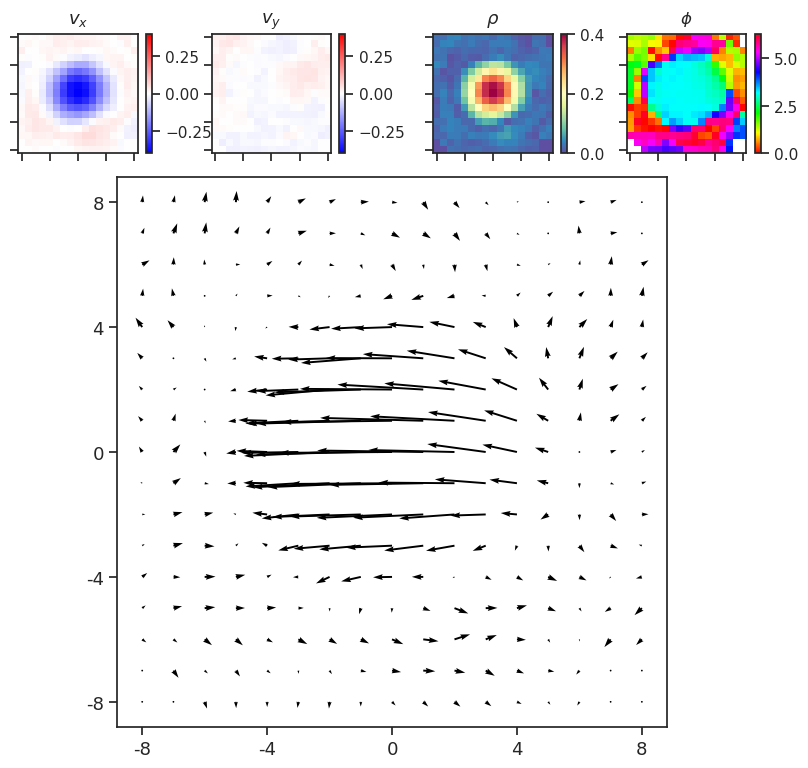

In [15]:
show_opticflow_full(sta_model.squeeze());

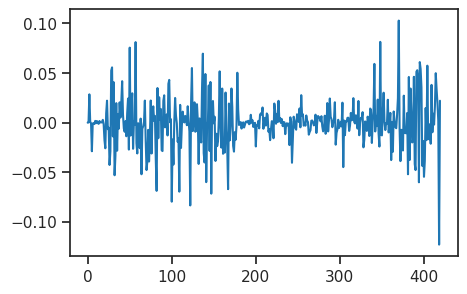

In [16]:
c = ro.mod[cell].coef_
plt.plot(c);

In [24]:
%%time

perm = sk_inspect.permutation_importance(
    estimator=ro.mod[cell],
    X=neural_data['x_tst'],
    y=neural_data['y_tst'],
    n_repeats=10,
    random_state=0,
)
perm_mu = np.maximum(0, perm['importances_mean'])
perm_sd = perm['importances_std']

CPU times: user 1min 11s, sys: 6.03 ms, total: 1min 11s
Wall time: 2.77 s


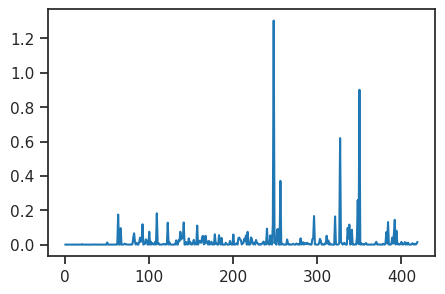

In [25]:
plt.plot(perm_mu)

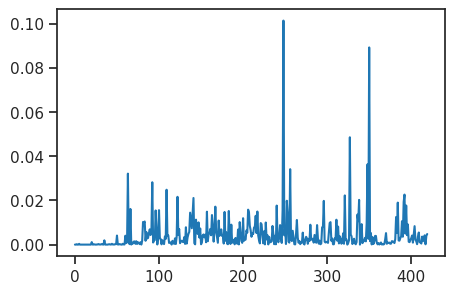

In [26]:
plt.plot(perm_sd)

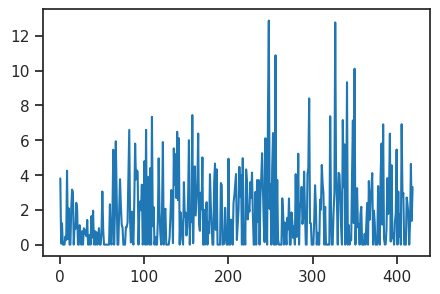

In [27]:
plt.plot(perm_mu / perm_sd)

In [28]:
p = perm_mu / perm_mu.sum()

In [29]:
1 - entropy_normalized(p, axis=0)

0.32763201340636516

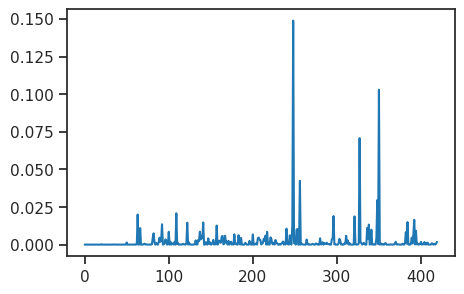

In [30]:
plt.plot(p)

In [31]:
important_latents = np.argsort(p)[::-1]
important_latents[:5]

array([248, 350, 327, 256, 348])

In [32]:
np.round(p[important_latents], 2)[:80]

array([0.15, 0.1 , 0.07, 0.04, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  ])

In [41]:
selected = [0, 1, 11, 12, 13, 18, 19, 20, 24, 25, 26]
labels = tr.dl_tst.dataset.f + tr.dl_tst.dataset.f_aux

print(list(np.array(labels)[selected]))

[
    'fix_x',
    'fix_y',
    'slf_v_x',
    'slf_v_y',
    'slf_v_z',
    'obj0_x',
    'obj0_y',
    'obj0_z',
    'obj0_v_x',
    'obj0_v_y',
    'obj0_v_z'
]

In [61]:
# Option 1
p_z_given_neuron = perm_mu / perm_mu.sum()

p_g_given_z = np.maximum(0, everything['importances_mu'])[selected]
p_g_given_z = p_g_given_z / p_g_given_z.sum(0, keepdims=True)
p_g_given_neuron = p_g_given_z @ p_z_given_neuron


# Option 2
p_neuron_given_z = perm_mu / perm_mu.sum()

p_z_given_g = np.maximum(0, everything['importances_mu'])[selected]
p_z_given_g = p_z_given_g / p_z_given_g.sum(1, keepdims=True)
p_neuron_given_g = p_z_given_g @ p_neuron_given_z
p_neuron_given_g /= sum(p_neuron_given_g)

In [62]:
p_z_given_neuron.sum(), p_g_given_neuron.sum()

(1.0, 0.9999999999999998)

In [63]:
collections.Counter(np.round(p_g_given_z.sum(0), 5)), collections.Counter(np.round(p_z_given_g.sum(1), 5))

(Counter({1.0: 420}), Counter({1.0: 11}))

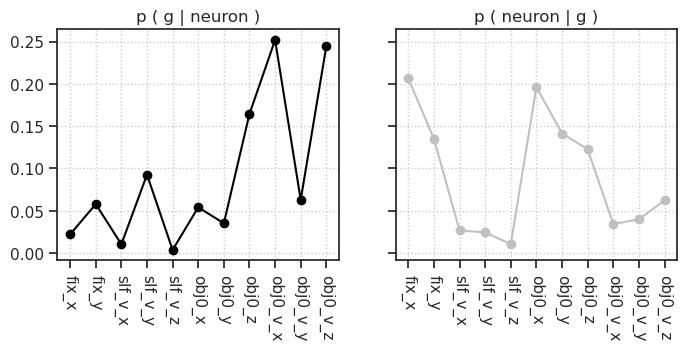

In [66]:
fig, axes = create_figure(1, 2, (8, 3), 'all', 'all')
axes[0].plot(p_g_given_neuron, marker='o', color='k')
axes[1].plot(p_neuron_given_g, marker='o', color='silver')

axes[0].set_title('p ( g | neuron )')
axes[1].set_title('p ( neuron | g )')

axes[0].set(
    xticks=range(len(selected)),
    xticklabels=list(np.array(labels)[selected]),
)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90)
    ax.grid()
plt.show()

## Another cell

In [6]:
%%time

expt, cell = 'clu040', 0
ro = ro_all[f'YUWEI_{expt}']
neural_data = ro.validate(cell)

neural_data['y'].sum() / (len(neural_data['y']) * 25e-3)

CPU times: user 19min 6s, sys: 1min 7s, total: 20min 13s
Wall time: 50.4 s


14.639718093077889

In [8]:
list(neural_data)

['x', 'y']

In [9]:
print({k: v.shape for k, v in neural_data.items()})

{'x': (24689, 420), 'y': (24689,)}

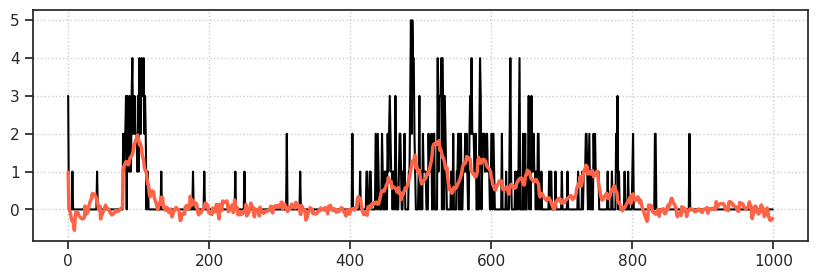

In [14]:
pred = ro.mod[cell].predict(neural_data['x'])
intvl = range(200, 1200)

fig, ax = create_figure(1, 1, (10, 3))
ax.plot(neural_data['y'][intvl], color='k', lw=1.5)
ax.plot(pred[intvl], color='tomato', lw=2.5)
ax.grid()
plt.show()

In [15]:
r = sp_stats.pearsonr(neural_data['y'], pred)[0]
r

0.5572073421975212

In [17]:
pred_full = ro.mod[cell].predict(neural_data['x'])
ro.stim[ro.good].shape, pred_full.shape

((24689, 2, 17, 17), (24689,))

In [18]:
sta_model = compute_sta(
    n_lags=0,
    stim=ro.stim[ro.good],
    spks=pred_full.reshape(-1, 1),
)

/home/hadi/Dropbox/git/_MTMST/analysis/linear.py:293: RuntimeWarning: NaN in STA
  warnings.warn("NaN in STA", RuntimeWarning)


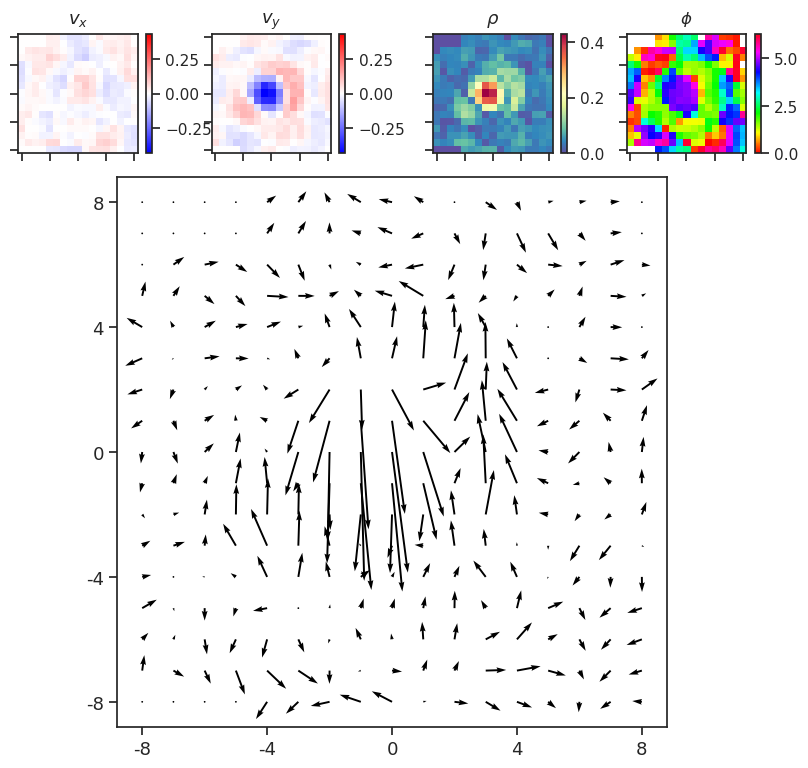

In [19]:
show_opticflow_full(sta_model.squeeze());

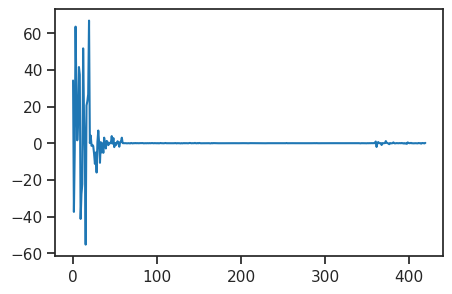

In [20]:
c = ro.mod[cell].coef_
plt.plot(c);

In [22]:
%%time

perm = sk_inspect.permutation_importance(
    estimator=ro.mod[cell],
    X=neural_data['x'],
    y=neural_data['y'],
    n_repeats=10,
    random_state=0,
)
perm_mu = np.maximum(0, perm['importances_mean'])
perm_sd = perm['importances_std']

CPU times: user 2min 6s, sys: 3.32 s, total: 2min 9s
Wall time: 44.9 s


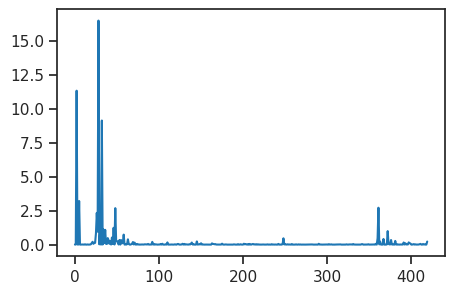

In [23]:
plt.plot(perm_mu)

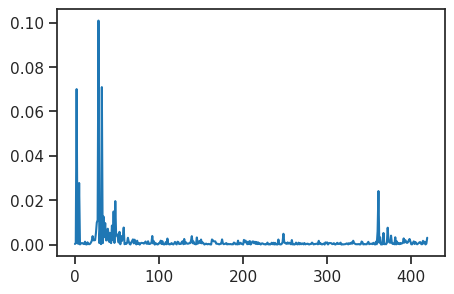

In [24]:
plt.plot(perm_sd)

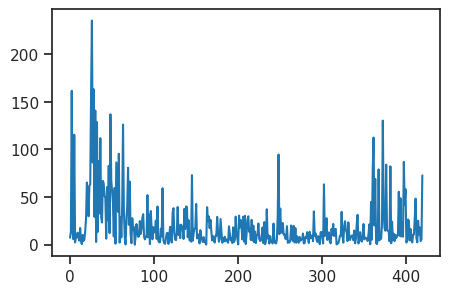

In [25]:
plt.plot(perm_mu / perm_sd)

In [26]:
p = perm_mu / perm_mu.sum()

In [27]:
1 - entropy_normalized(p, axis=0)

0.4924581316554747

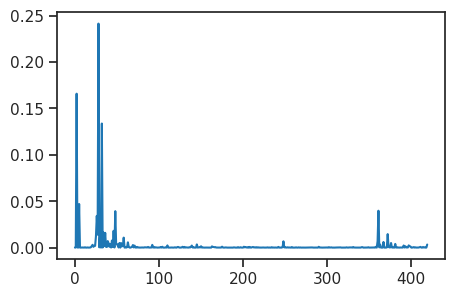

In [28]:
plt.plot(p)

In [29]:
important_latents = np.argsort(p)[::-1]
important_latents[:5]

array([ 28,   2,  32,   5, 361])

In [30]:
np.round(p[important_latents], 2)[:80]

array([0.24, 0.17, 0.13, 0.05, 0.04, 0.04, 0.03, 0.02, 0.02, 0.02, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  ])

In [31]:
selected = [0, 1, 11, 12, 13, 18, 19, 20, 24, 25, 26]
labels = tr.dl_tst.dataset.f + tr.dl_tst.dataset.f_aux

print(list(np.array(labels)[selected]))

[
    'fix_x',
    'fix_y',
    'slf_v_x',
    'slf_v_y',
    'slf_v_z',
    'obj0_x',
    'obj0_y',
    'obj0_z',
    'obj0_v_x',
    'obj0_v_y',
    'obj0_v_z'
]

In [32]:
# Option 1
p_z_given_neuron = perm_mu / perm_mu.sum()

p_g_given_z = np.maximum(0, everything['importances_mu'])[selected]
p_g_given_z = p_g_given_z / p_g_given_z.sum(0, keepdims=True)
p_g_given_neuron = p_g_given_z @ p_z_given_neuron


# Option 2
p_neuron_given_z = perm_mu / perm_mu.sum()

p_z_given_g = np.maximum(0, everything['importances_mu'])[selected]
p_z_given_g = p_z_given_g / p_z_given_g.sum(1, keepdims=True)
p_neuron_given_g = p_z_given_g @ p_neuron_given_z
p_neuron_given_g /= sum(p_neuron_given_g)

In [33]:
p_z_given_neuron.sum(), p_g_given_neuron.sum()

(1.0, 1.0)

In [34]:
collections.Counter(np.round(p_g_given_z.sum(0), 5)), collections.Counter(np.round(p_z_given_g.sum(1), 5))

(Counter({1.0: 420}), Counter({1.0: 11}))

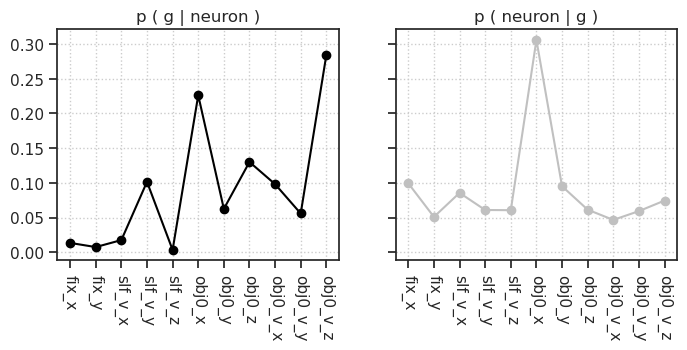

In [35]:
fig, axes = create_figure(1, 2, (8, 3), 'all', 'all')
axes[0].plot(p_g_given_neuron, marker='o', color='k')
axes[1].plot(p_neuron_given_g, marker='o', color='silver')

axes[0].set_title('p ( g | neuron )')
axes[1].set_title('p ( neuron | g )')

axes[0].set(
    xticks=range(len(selected)),
    xticklabels=list(np.array(labels)[selected]),
)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90)
    ax.grid()
plt.show()